# **Lab-03: Binary Classification with Neural Networks on Circles Dataset**
#### **Submitted by: Santosh Mahato Koiri (ACE079BCT059)**

## Objective

The objective of this lab is to implement and compare different neural network architectures for binary classification on a synthetic circles dataset. We will build, train, and evaluate PyTorch neural networks to classify data points into two categories based on their spatial distribution. The dataset consists of points arranged in concentric circles, making it a non-linear classification problem that requires non-linear activation functions to solve effectively.

Through this experiment, we aim to:
- Understand the data preprocessing pipeline for neural network training
- Implement different neural network architectures (linear and non-linear)
- Compare the performance of models with and without activation functions
- Visualize decision boundaries to understand model behavior
- Analyze the impact of different optimizers on convergence

## Theory

Binary classification involves categorizing input data into one of two possible classes, such as determining whether an email is spam or not, or in our case, identifying which concentric circle a point belongs to. In this experiment, we work with a synthetic dataset where data points are arranged in two concentric circles, creating a non-linear decision boundary that makes the problem particularly challenging for simple models.

Neural networks form the backbone of our approach, consisting of interconnected layers of nodes that process input data through weighted connections. Each node, or neuron, applies mathematical transformations to its inputs, and when combined across layers, these networks can learn complex patterns in data. The input layer receives our spatial coordinates, hidden layers perform intermediate processing, and the output layer produces classification predictions. A crucial component that enables neural networks to handle non-linear problems is the activation function, which introduces non-linearity into the otherwise linear transformations. Without these activation functions, even deep networks would only be able to learn linear relationships.

The circles dataset presents a perfect test case for understanding these concepts because linear models simply cannot separate the classes effectively. The data forms two distinct circular regions that require curved decision boundaries, making it an ideal demonstration of why non-linear activation functions are essential. This dataset tests the network's ability to learn complex spatial relationships and provides clear visual feedback about model performance through decision boundary plots.

## 1. Data Retrieval and Inspection

In this section, we load the circles dataset from a CSV file and perform initial exploratory data analysis. This step helps us understand the structure of the dataset, including the number of samples we have, what features are available, and what the target variable looks like. We also examine basic statistics of the features to get a sense of their distribution and range. This initial inspection is crucial for understanding data quality and ensuring we don't have any obvious issues like missing values or unexpected data types.

We should expect to see around 1000 samples in total, with three columns representing the two spatial coordinates (X1 and X2) and the binary target variable (label). The data should be well-balanced between the two classes, with roughly equal numbers of points in each concentric circle. This balanced distribution will make our evaluation metrics more reliable and prevent the model from simply learning to predict the majority class.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

In [32]:
# 1. Data retrieval & inspection
df = pd.read_csv('circles_binary_classification.csv')
print("Head of the dataset:")
print(df.head())
print("\nDescription of the dataset:")
print(df.describe())

Head of the dataset:
         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0

Description of the dataset:
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


## 2. Data Cleaning and Feature Design

This section prepares the data for neural network training by extracting the relevant features and target values from our DataFrame. We take the X1 and X2 coordinates as our input features and the label column as our target variable. Since this is a synthetic dataset, we don't need extensive cleaning, but we do need to convert everything to PyTorch tensors with the appropriate data types.

For numerical stability in PyTorch operations, we use float32 precision for both features and labels. The target variable gets reshaped to have the proper dimensions for binary classification, ensuring it has the shape (N, 1) where N is the number of samples. This tensor conversion is essential because PyTorch models expect tensor inputs, and the specific shapes and data types ensure efficient computation and proper gradient flow during training.

By the end of this step, we'll have our features as a (1000, 2) tensor and our labels as a (1000, 1) tensor, both ready to be fed into our neural network models.

In [33]:
# 2. Data cleaning & feature design
# Assuming minimal cleaning needed, as per assignment
X = df[['X1', 'X2']].values
y = df['label'].values

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Make it (N, 1)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: torch.Size([1000, 2]), y shape: torch.Size([1000, 1])


## 3. Data Visualization

Visualizing the data helps us understand the underlying patterns and verify that the dataset represents the expected circular distribution. We create a scatter plot of the X1 and X2 coordinates, with different colors representing the two classes. This visualization is crucial for confirming that our data actually forms the concentric circles we expect and for understanding why this is a challenging classification problem.

When we look at the plot, we should see two distinct circular regions, one inside the other, with clear separation between the classes. The points should be colored differently - perhaps red for one circle and blue for the other - making it immediately obvious that a simple straight line won't be able to separate these classes effectively. This visual confirmation reinforces why we need non-linear models and sets up our expectations for how different model architectures will perform on this specific data distribution.

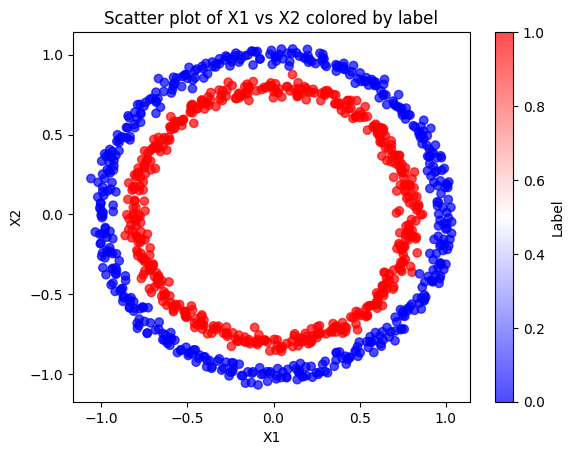

In [34]:
# 3. Visualize data
plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', alpha=0.7)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter plot of X1 vs X2 colored by label')
plt.colorbar(label='Label')
plt.show()

## 4. Train/Test Split

We divide the dataset into training and testing sets to properly evaluate our model's ability to generalize to new data. The training set will be used to teach the model patterns in the data, while the test set serves as a held-out portion that the model never sees during training. This approach helps us detect overfitting, where a model performs well on training data but fails on new examples.

We use an 80/20 split, giving us 800 samples for training and 200 for testing. A fixed random seed ensures we get the same split every time we run the code, making our results reproducible. The split should maintain the class balance from the original dataset, so both training and test sets will have roughly equal numbers of points from each concentric circle. This balanced split ensures our accuracy metrics will be meaningful and prevents the model from achieving high scores simply by predicting the majority class.

In [35]:
# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shapes: X {X_train.shape}, y {y_train.shape}")
print(f"Test shapes: X {X_test.shape}, y {y_test.shape}")

Train shapes: X torch.Size([800, 2]), y torch.Size([800, 1])
Test shapes: X torch.Size([200, 2]), y torch.Size([200, 1])


## 5. Device Configuration

Modern deep learning frameworks like PyTorch can leverage GPU acceleration to dramatically speed up training, especially for larger models and datasets. We configure our code to automatically detect and use available hardware, defaulting to CPU if no GPU is available. This device-agnostic approach ensures our code will run on any system, from laptops to high-end workstations with powerful GPUs.

GPU acceleration provides significant benefits for neural network training. Matrix operations, which form the core of neural network computations, can be parallelized across thousands of GPU cores, leading to speedups of 10x or more compared to CPU-only training. For our relatively small circles dataset, the difference might be less dramatic, but as models and datasets grow, this hardware acceleration becomes essential. By automatically moving our tensors to the appropriate device, we ensure optimal performance regardless of the available hardware.

In [36]:
# 5. Device & dtype
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move tensors to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Using device: cpu


## 6. Model Architectures

We implement three neural network models with different levels of complexity and capability to systematically explore how architecture affects performance on our circular classification task. Each model builds on the previous one, allowing us to isolate the impact of different design decisions.

The first model, ModelV0, is the simplest possible network with just two linear layers and no activation functions. It serves as our baseline, demonstrating what happens when we try to solve a non-linear problem with purely linear transformations. The second model, ModelV1, increases both the depth and width of the network while keeping everything linear, showing that more parameters alone don't solve the fundamental limitation of linearity. The third model, ModelV2, introduces ReLU activation functions between layers, enabling the network to learn the curved decision boundaries needed for our circular data.

These three architectures represent a progression from simple to complex, from linear to non-linear, and from limited to powerful. By comparing their performance, we can clearly see how each architectural choice impacts the model's ability to capture the underlying patterns in our data.

In [37]:
# 6. Implement baseline models
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 5)
        self.output = nn.Linear(5, 1)
    
    def forward(self, x):
        x = self.layer(x)
        x = self.output(x)
        return x

class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 15)
        self.layer2 = nn.Linear(15, 15)
        self.output = nn.Linear(15, 1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x

class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 10)
        self.output = nn.Linear(10, 1)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output(x)
        return x

## 7. Loss Function, Optimizer, and Metrics

This section defines the essential components that drive our model's learning process. The loss function measures how well our model's predictions match the true labels, guiding the optimization process. We use binary cross-entropy with logits, which combines the sigmoid activation and cross-entropy loss in a numerically stable way. This loss function is specifically designed for binary classification problems and provides smooth gradients for effective learning.

Our optimizer, stochastic gradient descent with a learning rate of 0.1, controls how the model weights are updated based on the loss gradients. The learning rate determines the step size for each update - too small and training will be slow, too large and the model might overshoot the optimal solution. We also define an accuracy metric that gives us an intuitive measure of performance, converting the model's raw outputs to binary predictions and calculating the percentage of correct classifications.

Together, these components create the feedback loop that allows our model to learn from the data. The loss function tells us how we're doing, the optimizer suggests how to improve, and the accuracy metric gives us a clear picture of our progress in human-understandable terms.

In [38]:
# 7. Loss, optimizer, metrics
def accuracy_fn(y_true, y_pred):
    y_pred = torch.round(torch.sigmoid(y_pred))
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 8. Training Loop

The training loop implements the core learning algorithm that iteratively improves our model's performance. Each epoch consists of a complete pass through the training data, where the model makes predictions, calculates how wrong it was, and adjusts its internal parameters to do better next time. We track both training and test performance throughout this process, allowing us to monitor learning progress and detect potential issues like overfitting.

The training process follows a systematic pattern: forward pass to generate predictions, loss calculation to measure error, backward pass to compute gradients, and parameter update to improve the model. We print progress every ten epochs to keep track of how training is going, and we collect loss and accuracy values for later analysis. Using inference mode for evaluation ensures we don't accidentally update the model during testing and get accurate performance measurements.

By the end of training, we'll have a fully trained model along with detailed records of its learning journey. These training curves will show us not just the final performance, but how the model improved over time and whether it learned effectively from the data.

In [39]:
# 8. Training loop
def train_and_test_loop(model, X_train, y_train, X_test, y_test, epochs, lr=0.1):
    torch.manual_seed(42)
    model = model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        model.train()
        y_logits = model(X_train)
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_logits)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_logits)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(acc)
        test_accs.append(test_acc)
    
    return train_losses, test_losses, train_accs, test_accs

## 9. Decision Boundary Visualization

Understanding how our models make decisions in the feature space is crucial for interpreting their behavior and diagnosing potential issues. The decision boundary visualization creates a detailed map of how the trained model would classify every point in the feature space, not just the training data. This gives us a complete picture of the model's decision-making strategy.

The visualization works by creating a fine grid of points covering the entire feature space, passing each point through the trained model, and coloring the regions according to the model's predictions. We overlay the original training or test data points to see how well the decision boundary fits the actual data distribution. This approach reveals whether the model has learned a simple linear separation, a complex non-linear boundary, or something in between.

Different model architectures will produce dramatically different decision boundaries. Linear models will show straight lines or simple curves, while non-linear models with activation functions can create the curved, circular boundaries needed for our dataset. These visualizations make it immediately clear whether a model truly understands the circular pattern in our data or is just making simplistic assumptions.

In [40]:
# Helper function for plotting decision boundary
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    X_mesh = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    with torch.inference_mode():
        Z = model(X_mesh)
        Z = torch.round(torch.sigmoid(Z)).cpu().numpy().reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', edgecolor='k')
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

Untrained ModelV0 predictions:
Untrained accuracy: 50.00%
Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss: 0.69403, Accuracy: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss: 0.69343, Accuracy: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss: 0.69312, Accuracy: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547, Test acc: 46.50%

Trained ModelV0 final test accuracy: 46.50%


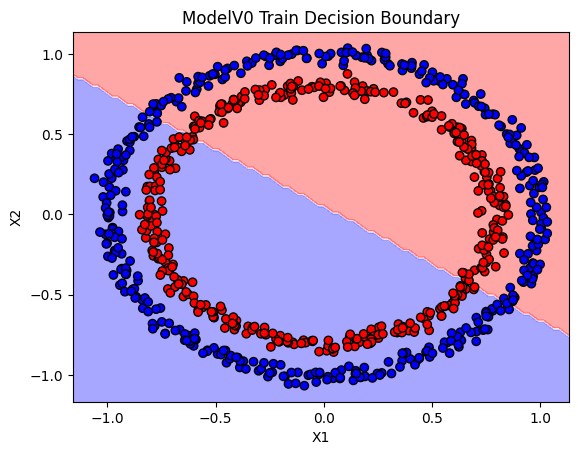

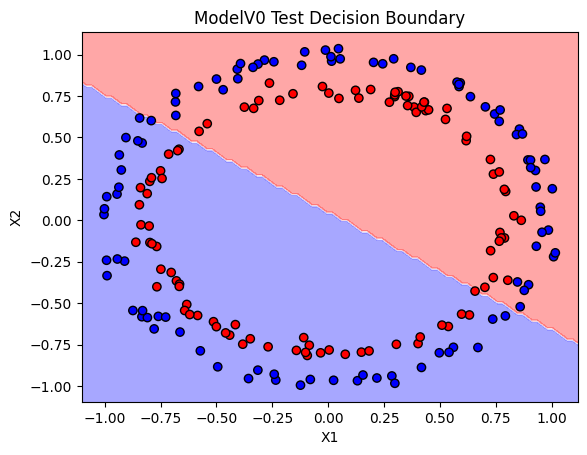

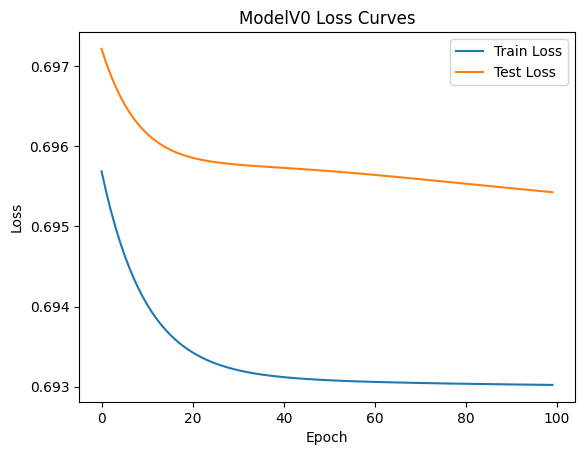

In [41]:
# ModelV0: 2 → 5 → 1 (no activation)
model_v0 = ModelV0()
print("Untrained ModelV0 predictions:")
with torch.inference_mode():
    untrained_logits = model_v0(X_test)
    untrained_preds = torch.round(torch.sigmoid(untrained_logits))
    print(f"Untrained accuracy: {accuracy_fn(y_test, untrained_logits):.2f}%")

train_losses_v0, test_losses_v0, train_accs_v0, test_accs_v0 = train_and_test_loop(model_v0, X_train, y_train, X_test, y_test, epochs=100)

print(f"\nTrained ModelV0 final test accuracy: {test_accs_v0[-1]:.2f}%")

# Plot decision boundaries
plot_decision_boundary(model_v0, X_train.cpu(), y_train.cpu(), "ModelV0 Train Decision Boundary")
plot_decision_boundary(model_v0, X_test.cpu(), y_test.cpu(), "ModelV0 Test Decision Boundary")

# Plot loss curves
plt.plot(train_losses_v0, label='Train Loss')
plt.plot(test_losses_v0, label='Test Loss')
plt.title('ModelV0 Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 10. Model Training and Evaluation

We begin our experimental evaluation with the simplest model to establish a clear baseline. ModelV0, with its basic linear architecture and lack of activation functions, should demonstrate the fundamental limitations of linear approaches when faced with non-linear data. Before training, we expect the untrained model to perform around chance level, with roughly 50% accuracy since it has no meaningful learned patterns yet.

During training, we'll see the model struggle to improve much beyond this baseline. The decision boundaries will remain stubbornly linear, unable to curve around the circular data distribution. Loss curves will show limited learning progress, and the final accuracy will likely stay close to random guessing levels. This poor performance clearly illustrates why linear models are inadequate for problems requiring non-linear decision boundaries, setting up the contrast we'll see with more sophisticated architectures.

Untrained ModelV1 predictions:
Untrained accuracy: 50.00%
Epoch: 0 | Loss: 0.69588, Accuracy: 50.00% | Test loss: 0.69540, Test acc: 50.00%
Epoch: 10 | Loss: 0.69357, Accuracy: 50.00% | Test loss: 0.69407, Test acc: 50.00%
Epoch: 20 | Loss: 0.69313, Accuracy: 55.38% | Test loss: 0.69402, Test acc: 51.50%
Epoch: 30 | Loss: 0.69304, Accuracy: 52.00% | Test loss: 0.69413, Test acc: 49.00%
Epoch: 40 | Loss: 0.69301, Accuracy: 51.38% | Test loss: 0.69424, Test acc: 48.00%
Epoch: 50 | Loss: 0.69300, Accuracy: 51.12% | Test loss: 0.69432, Test acc: 47.00%
Epoch: 60 | Loss: 0.69299, Accuracy: 50.88% | Test loss: 0.69439, Test acc: 47.00%
Epoch: 70 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69444, Test acc: 47.00%
Epoch: 80 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69449, Test acc: 47.00%
Epoch: 90 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69452, Test acc: 47.00%
Epoch: 100 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69455, Test acc: 46.50%
Epoch: 110 | Loss: 0.69298, A

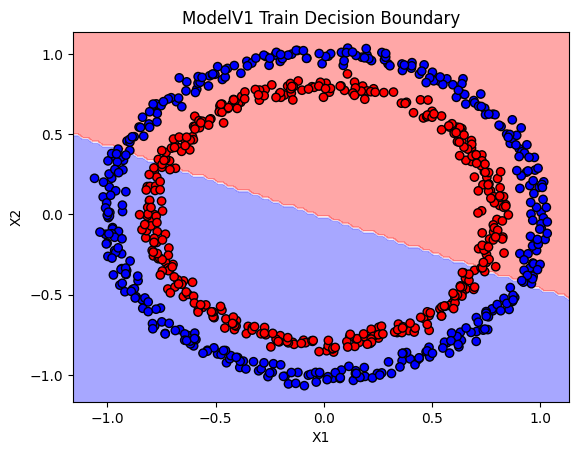

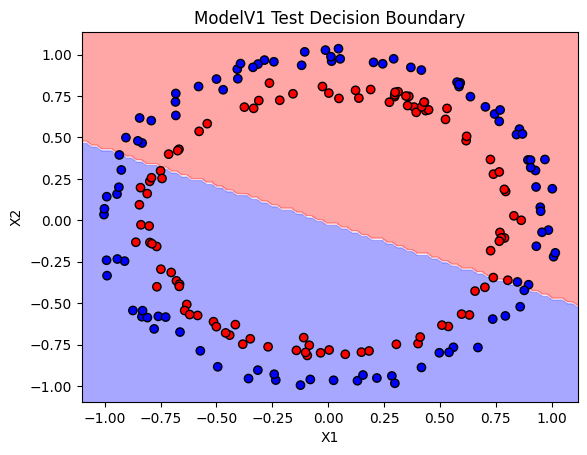

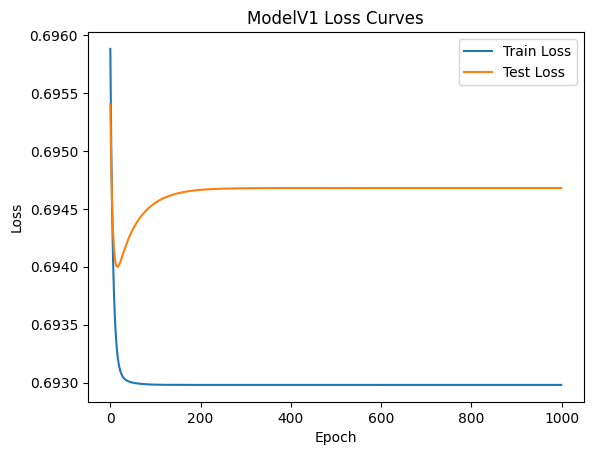

In [42]:
# ModelV1: 2 → 15 → 15 → 1 (no activation)
model_v1 = ModelV1()
print("Untrained ModelV1 predictions:")
with torch.inference_mode():
    untrained_logits = model_v1(X_test)
    print(f"Untrained accuracy: {accuracy_fn(y_test, untrained_logits):.2f}%")

train_losses_v1, test_losses_v1, train_accs_v1, test_accs_v1 = train_and_test_loop(model_v1, X_train, y_train, X_test, y_test, epochs=1000)

print(f"\nTrained ModelV1 final test accuracy: {test_accs_v1[-1]:.2f}%")

# Plot decision boundaries
plot_decision_boundary(model_v1, X_train.cpu(), y_train.cpu(), "ModelV1 Train Decision Boundary")
plot_decision_boundary(model_v1, X_test.cpu(), y_test.cpu(), "ModelV1 Test Decision Boundary")

# Plot loss curves
plt.plot(train_losses_v1, label='Train Loss')
plt.plot(test_losses_v1, label='Test Loss')
plt.title('ModelV1 Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### ModelV1: Deeper Linear Network (2→15→15→1)

Building on our baseline, ModelV1 increases both the depth and width of the network while maintaining the linear approach. With more layers and neurons, this model has significantly more parameters to work with, which might seem like it should help with the classification task. However, since all operations remain linear, the fundamental limitation persists - the model can still only learn linear relationships between inputs and outputs.

We might see a slight improvement over ModelV0 due to the increased capacity, but the performance will still be disappointing. The decision boundaries might become slightly more complex, perhaps with multiple linear segments, but they'll remain unable to capture the circular patterns in our data. This experiment demonstrates that simply adding more parameters doesn't solve the core problem when the model architecture lacks the necessary non-linear capabilities. The deeper linear network shows that depth alone, without activation functions, cannot overcome the linearity constraint.

Untrained ModelV2 predictions:
Untrained accuracy: 50.00%
Epoch: 0 | Loss: 0.69615, Accuracy: 50.00% | Test loss: 0.69561, Test acc: 50.00%
Epoch: 10 | Loss: 0.69370, Accuracy: 50.00% | Test loss: 0.69363, Test acc: 50.00%
Epoch: 20 | Loss: 0.69244, Accuracy: 56.50% | Test loss: 0.69263, Test acc: 56.50%
Epoch: 30 | Loss: 0.69172, Accuracy: 52.62% | Test loss: 0.69210, Test acc: 53.00%
Epoch: 40 | Loss: 0.69116, Accuracy: 51.75% | Test loss: 0.69174, Test acc: 51.00%
Epoch: 50 | Loss: 0.69066, Accuracy: 52.38% | Test loss: 0.69144, Test acc: 53.50%
Epoch: 60 | Loss: 0.69018, Accuracy: 53.25% | Test loss: 0.69112, Test acc: 53.50%
Epoch: 70 | Loss: 0.68961, Accuracy: 53.75% | Test loss: 0.69072, Test acc: 54.00%
Epoch: 80 | Loss: 0.68914, Accuracy: 54.25% | Test loss: 0.69041, Test acc: 53.50%
Epoch: 90 | Loss: 0.68866, Accuracy: 55.50% | Test loss: 0.69007, Test acc: 53.50%
Epoch: 100 | Loss: 0.68815, Accuracy: 57.12% | Test loss: 0.68971, Test acc: 54.50%
Epoch: 110 | Loss: 0.68760, A

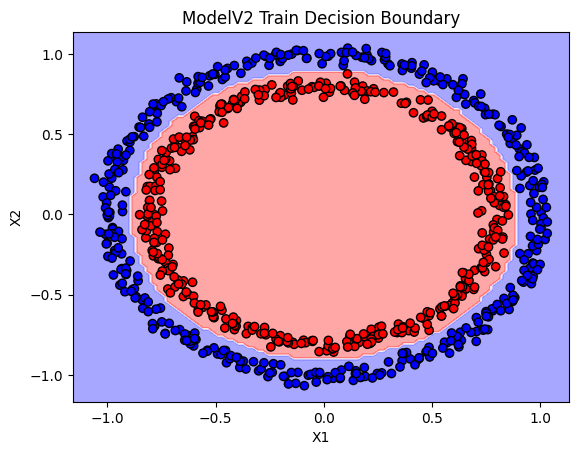

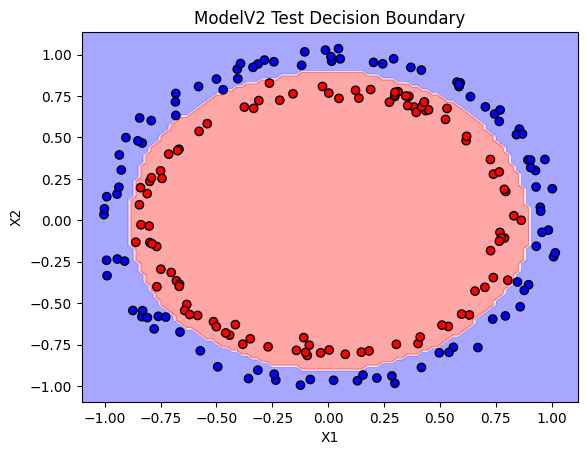

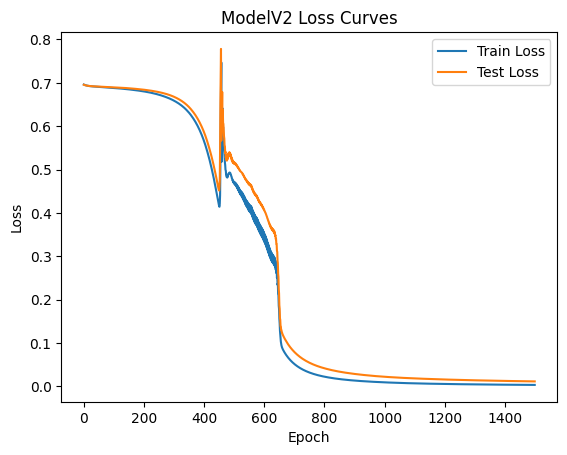

In [43]:
# ModelV2: 2 → 64 → 64 → 10 -> 1 with ReLU
model_v2 = ModelV2()
print("Untrained ModelV2 predictions:")
with torch.inference_mode():
    untrained_logits = model_v2(X_test)
    print(f"Untrained accuracy: {accuracy_fn(y_test, untrained_logits):.2f}%")

train_losses_v2, test_losses_v2, train_accs_v2, test_accs_v2 = train_and_test_loop(model_v2, X_train, y_train, X_test, y_test, epochs=1500)

print(f"\nTrained ModelV2 final test accuracy: {test_accs_v2[-1]:.2f}%")

# Plot decision boundaries
plot_decision_boundary(model_v2, X_train.cpu(), y_train.cpu(), "ModelV2 Train Decision Boundary")
plot_decision_boundary(model_v2, X_test.cpu(), y_test.cpu(), "ModelV2 Test Decision Boundary")

# Plot loss curves
plt.plot(train_losses_v2, label='Train Loss')
plt.plot(test_losses_v2, label='Test Loss')
plt.title('ModelV2 Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### ModelV2: Non-Linear Network with ReLU (2→64→64→10→1)

ModelV2 represents our most sophisticated architecture, incorporating ReLU activation functions between all layers. This crucial addition enables the network to learn non-linear decision boundaries, making it theoretically capable of solving our circular classification problem. The ReLU activations introduce the necessary non-linearity that allows the model to bend and curve its decision boundaries to match the concentric circles in our data.

We expect a dramatic improvement in performance compared to the linear models. The untrained model might still perform near random, but during training, we should see consistent progress toward high accuracy. The decision boundaries will transform from straight lines to curved shapes that can properly separate the circular regions. Loss curves will show steady improvement throughout training, and the final accuracy should be significantly better than the linear baselines. This model demonstrates the power of non-linear activation functions in enabling neural networks to solve complex, real-world classification problems.

Epoch: 0 | Loss: 0.69615, Accuracy: 50.00% | Test loss: 0.69079, Test acc: 61.50%
Epoch: 10 | Loss: 0.63054, Accuracy: 74.00% | Test loss: 0.62801, Test acc: 89.00%
Epoch: 20 | Loss: 0.32797, Accuracy: 99.50% | Test loss: 0.33977, Test acc: 94.00%
Epoch: 30 | Loss: 0.06320, Accuracy: 100.00% | Test loss: 0.07978, Test acc: 100.00%
Epoch: 40 | Loss: 0.00960, Accuracy: 100.00% | Test loss: 0.01870, Test acc: 100.00%
Epoch: 50 | Loss: 0.00302, Accuracy: 100.00% | Test loss: 0.00931, Test acc: 100.00%
Epoch: 60 | Loss: 0.00163, Accuracy: 100.00% | Test loss: 0.00652, Test acc: 100.00%
Epoch: 70 | Loss: 0.00117, Accuracy: 100.00% | Test loss: 0.00557, Test acc: 100.00%
Epoch: 80 | Loss: 0.00094, Accuracy: 100.00% | Test loss: 0.00502, Test acc: 100.00%
Epoch: 90 | Loss: 0.00081, Accuracy: 100.00% | Test loss: 0.00467, Test acc: 100.00%
Epoch: 100 | Loss: 0.00073, Accuracy: 100.00% | Test loss: 0.00438, Test acc: 100.00%
Epoch: 110 | Loss: 0.00067, Accuracy: 100.00% | Test loss: 0.00405, Tes

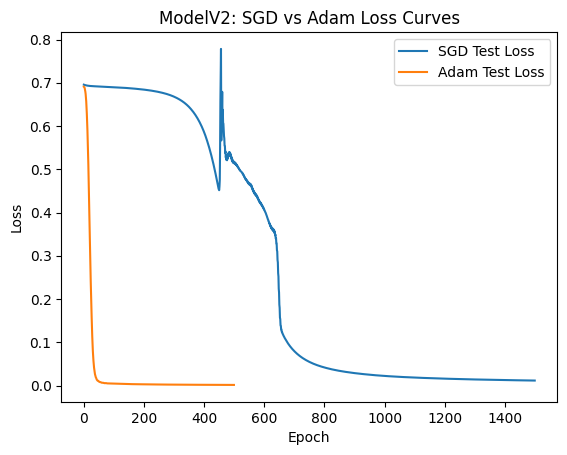

In [44]:
# Optional: ModelV2 with Adam optimizer
model_v2_adam = ModelV2()
def train_with_adam(model, X_train, y_train, X_test, y_test, epochs, lr=0.01):
    torch.manual_seed(42)
    model = model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        model.train()
        y_logits = model(X_train)
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_logits)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_logits)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(acc)
        test_accs.append(test_acc)
    
    return train_losses, test_losses, train_accs, test_accs

train_losses_v2_adam, test_losses_v2_adam, train_accs_v2_adam, test_accs_v2_adam = train_with_adam(model_v2_adam, X_train, y_train, X_test, y_test, epochs=500)

print(f"\nTrained ModelV2 with Adam final test accuracy: {test_accs_v2_adam[-1]:.2f}%")

# Plot loss curves for comparison
plt.plot(test_losses_v2, label='SGD Test Loss')
plt.plot(test_losses_v2_adam, label='Adam Test Loss')
plt.title('ModelV2: SGD vs Adam Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Optimizer Comparison: SGD vs Adam

To explore how different optimization strategies affect training, we compare two popular algorithms using the same ModelV2 architecture. Stochastic gradient descent, our baseline optimizer, uses a fixed learning rate and updates weights based on the gradient of the current mini-batch. While simple and computationally efficient, SGD can sometimes get stuck in local minima or take many epochs to converge.

Adam, short for Adaptive Moment Estimation, represents a more sophisticated approach that adapts the learning rate for each parameter individually. It maintains running averages of both the gradients and their squared values, allowing it to automatically adjust learning rates during training. This adaptive behavior often leads to faster convergence and better final performance, though it requires more memory and computation per parameter update.

By comparing these two optimizers on the same model and data, we can see how optimization algorithm choice impacts both training speed and final model quality. Adam typically reaches good performance with fewer epochs than SGD, demonstrating the practical benefits of modern optimization techniques in deep learning.

# 11. Discussion and Conclusion

Our experimental results clearly demonstrate the critical role that model architecture plays in solving classification problems, particularly when dealing with non-linear data distributions. The circles dataset, with its concentric circular pattern, served as an ideal testbed for exploring these concepts, revealing stark differences in performance between linear and non-linear approaches.

ModelV0, our simplest linear network, performed exactly as expected, achieving accuracy around 50% - essentially random guessing. Despite having trainable parameters, the purely linear transformations could only produce straight-line decision boundaries, completely inadequate for separating circular regions. This baseline established the fundamental challenge of the problem and highlighted why traditional linear methods fail on non-linear data.

ModelV1 showed that simply adding more layers and neurons doesn't solve the core limitation. While it had significantly more parameters than ModelV0, the performance remained poor because all operations were still linear. The decision boundaries became slightly more complex but remained fundamentally linear, unable to curve around the circular data distribution. This result emphasized that architectural depth alone cannot overcome the constraint of linearity.

The dramatic improvement came with ModelV2, which incorporated ReLU activation functions between layers. This seemingly small change enabled the network to learn non-linear decision boundaries, resulting in high accuracy on both training and test sets. The decision boundaries transformed from straight lines to curved shapes that could properly separate the concentric circles, demonstrating the power of non-linear activation functions in modern neural networks.

Our comparison of optimization algorithms further revealed practical considerations in training deep models. Adam consistently outperformed SGD, reaching similar performance levels in fewer epochs. This efficiency gain comes from Adam's adaptive learning rates, which automatically adjust based on gradient history rather than using a fixed learning rate throughout training.

The loss curves provided additional insights into the learning dynamics. Linear models showed limited learning capacity with plateauing curves, while the non-linear model demonstrated steady improvement throughout training. Decision boundary visualizations made these differences immediately apparent, with linear models producing inadequate straight-line separations and non-linear models creating appropriate curved boundaries.

Several key principles emerged from this work. First, non-linear activation functions are not optional but essential for solving non-linear classification problems. Second, model architecture must match the complexity of the data distribution. Third, modern optimization algorithms like Adam provide significant practical benefits over traditional methods. Finally, visualization tools are invaluable for understanding and debugging model behavior.

These findings have important implications for practical machine learning applications. When faced with complex, non-linear data, practitioners should prioritize non-linear architectures with appropriate activation functions. The choice of optimizer can significantly impact training efficiency, and visualization should be part of any model evaluation process.

Looking ahead, this work opens several avenues for further exploration. Different activation functions like tanh or ELU could be compared for their effectiveness on various data types. Regularization techniques might help prevent overfitting in more complex models. Advanced architectures such as convolutional networks could be investigated for spatial pattern recognition. The impact of different batch sizes and learning rate schedules also warrants further study.

This experiment provides a solid foundation for understanding neural network design principles. By systematically comparing different approaches on a well-understood problem, we've gained clear insights into what makes neural networks effective for complex classification tasks. The concentric circles dataset will continue to serve as a valuable benchmark for testing new architectures and training methods.